#Segmenting Simple Picture with Leaves Only using Sobel Edge Detection

Test Dataset: https://www.tensorflow.org/datasets/catalog/plant_leaves

In [39]:
import numpy as np
import os.path
from time import time
import types
import matplotlib.pyplot as plt
import cv2

In [40]:
import math
import numpy as np
import PIL.Image as pil
import scipy.signal as sps
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def compute_gradients(img):

  Ix=np.zeros_like(img)
  Iy=np.zeros_like(img)

  # extract the size of the input image
  h, w, b = img.shape

  # compute gradients using finite differences
  for y in range(1, h - 1):
      for x in range(1, w - 1):
        # compute x-gradient (Ix)
        Ix[y, x] = (img[y, x + 1] - img[y, x - 1]) / 2.0

        # Compute y-gradient (Iy)
        Iy[y, x] = (img[y + 1, x] - img[y - 1, x]) / 2.0

  return Ix, Iy

def compute_sobel(img):

  Sx=np.zeros_like(img)
  Sy=np.zeros_like(img)

  # extract dimensions of the input image
  h, w = img.shape[:2]

  # Sobel kernels
  kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  # loop through the pixels that are in the inner side of the image
  for y in range(1, h - 1):
      for x in range(1, w - 1):
          # x-gradient (Sx) using the Sobel kernel
          Sx[y, x] = np.sum(img[y - 1:y + 2, x - 1:x + 2] * kernel_x)

          # y-gradient (Sy) using the Sobel kernel
          Sy[y, x] = np.sum(img[y - 1:y + 2, x - 1:x + 2] * kernel_y)

  return Sx, Sy

def image_open(filename):
  """
  Returns a numpy float image with values in the range (0,1)
  """
  pil_im = pil.open(filename)
  im_np = np.array(pil_im).astype(np.float32)
  im_np /= 255.0
  return im_np

def image_save(im_np, filename):
  """
  Saves a numpy float image to file
  """
  if (len(im_np.shape)==2):
    im_np = np.expand_dims(im_np, 2)
  if (im_np.shape[2]==1):
    im_np= np.repeat(im_np, 3, axis=2)
  im_np = np.maximum(0.0, np.minimum(im_np, 1.0))
  pil_im = pil.fromarray((im_np*255).astype(np.uint8))
  pil_im.save(filename)

def plot_many_images(*imgs):
  """
  Plot two images and return axis handles
  """
  count = len(imgs)
  axs = []
  for i in range(count):
    axs.append(plt.subplot(1,count,i+1))
    plt.imshow(imgs[i])
    plt.axis('off')
  return axs

def normalise_01(im):
  """
  Normalise image to the range (0,1)
  """
  mx = im.max()
  mn = im.min()
  den = mx-mn
  small_val = 1e-9
  if (den < small_val):
    print('image normalise_01 -- divisor is very small')
    den = small_val
  return (im-mn)/den

def grey_to_rgb(img):
  """
  Convert greyscale to rgb image
  """
  if (len(img.shape)==2):
    img = np.expand_dims(img, 2)

  img3 = np.repeat(img, 3, 2)
  return img3

def disc_mask(l):
  """
  Create a binary cirular mask of radius l
  """
  sz = 2 * l + 1
  m = np.zeros((sz,sz))
  x = np.linspace(-l,l,2*l+1)/l
  x = np.expand_dims(x, 1)
  m = x**2
  m = m + m.T
  m = m<1
  m = np.expand_dims(m, 2)
  return m

# allow accessing these functions by im_util.*
im_util=types.SimpleNamespace()
im_util.compute_gradients=compute_gradients
im_util.compute_sobel=compute_sobel
im_util.image_open=image_open
im_util.image_save=image_save
im_util.plot_many_images=plot_many_images
im_util.normalise_01=normalise_01
im_util.grey_to_rgb=grey_to_rgb
im_util.disc_mask=disc_mask

# Detecting Leaf from A More Complex Picture

In [41]:
"""
Helper functions
"""
# Function to compute sobel gray
def compute_sobel_gray(image_filename):
  im = im_util.image_open(image_filename)
  # Resize the image
  im = cv2.resize(im, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)

  # Compute Sobel for each color channel
  Sx_out = np.zeros_like(im)
  Sy_out = np.zeros_like(im)

  for channel in range(3):
    channel_im = im[:, :, channel]
    Sx = im_util.compute_sobel(channel_im)[0]
    Sy = im_util.compute_sobel(channel_im)[1]
    Sx_out[:, :, channel] = Sx
    Sy_out[:, :, channel] = Sy

  sobel_magnitude = np.sqrt(Sx_out**2 + Sy_out**2)
  # Convert Sobel magnitude to grayscale
  sobel_gray = cv2.cvtColor(sobel_magnitude, cv2.COLOR_RGB2GRAY)

  return im, sobel_gray

def find_edges(im, sobel_gray):
  # Set a threshold to extract brighter pixels
  threshold_value = 0.5

  # Set a green threshold
  green_threshold_lower = 0.6
  green_threshold_upper = 0.8

  im_new = np.copy(im)

  # Mask with edge pixels marked 1
  edge_mask = np.zeros((400,600))

  # H, W = sobel_gray.shape
  for h in range(400):
    for w in range(600):
      if sobel_gray[h][w] > threshold_value:
        edge_mask[h][w] = 1.0

  # for h in range(400):
  #   for w in range(600):
  #     if edge_mask[h][w] == 1.0:
  #       im_new[h][w] = (255,0,0)

  # # Calculate row and column densities
  # row_density = np.sum(edge_mask, axis=1)
  # col_density = np.sum(edge_mask, axis=0)

  # # Find rows and columns with higher density
  # high_density_rows = np.where(row_density > 0.43 * max(row_density))[0]
  # high_density_cols = np.where(col_density > 0.43 * max(col_density))[0]

  # # Find the bounding box around the region with higher density
  # min_row, max_row, min_col, max_col = min(high_density_rows), max(high_density_rows), min(high_density_cols), max(high_density_cols)

  # # Draw a rectangle around the region with higher density
  # cv2.rectangle(im_new, (min_col, min_row), (max_col, max_row), (0, 255, 0), 2)  # Draw a green rectangle


  # Display the result
  return edge_mask


"""
Function to segment leaf and draw edges
"""
def edge_detection(image_filename):
  im, sobel_gray = compute_sobel_gray(image_filename)
  edges = find_edges(im, sobel_gray)

# Segmenting Leaf

In [42]:
import cv2
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy import ndimage as ndi

# The steps which are suggested in the paper
# Improve/standardise the image
# Detect the color characteristics of the background
# Reconstruct a better image
# Create a collection of masks based on various characteristics of the image
# Process the masks and combine them in a final mask
# Use the final mask to make the background black

def segment(image_filename):

  # Detect edges in the image
  edges = edge_detection(image_filename)

  image = im_util.image_open(image_filename)
  # Convert the image to Lab color space
  image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)

  # Split into L, a, b channels
  l, a, b = cv2.split(image_lab)

   # Apply a Gaussian blur to the L, a, and b channels
  l_blurred = cv2.GaussianBlur(l, (5, 5), 0)
  a_blurred = cv2.GaussianBlur(a, (5, 5), 0)
  b_blurred = cv2.GaussianBlur(b, (5, 5), 0)

  # Calculate the median color of the image edges
  median_a = np.median(a_blurred[edges != 0])
  median_b = np.median(b_blurred[edges != 0])

  # Shift the a and b channels so that the background becomes gray
  a_shifted = a_blurred - (median_a - 128)
  b_shifted = b_blurred - (median_b - 128)

  # Ensure the shifted channels have the same size and type as the L channel
  a_shifted = cv2.resize(a_shifted, (l_blurred.shape[1], l_blurred.shape[0]))
  b_shifted = cv2.resize(b_shifted, (l_blurred.shape[1], l_blurred.shape[0]))
  a_shifted = a_shifted.astype(l_blurred.dtype)
  b_shifted = b_shifted.astype(l_blurred.dtype)

  # Reconstruct the Lab image
  image_lab_shifted = cv2.merge((l_blurred, a_shifted, b_shifted))

  # Convert back to RGB to apply the mask
  image_rgb_shifted = cv2.cvtColor(image_lab_shifted, cv2.COLOR_Lab2RGB)

  # Threshold the a and b channels to create the masks
  # These thresholds are arbitrary and you might need to adjust them
  _, color_mask = cv2.threshold(a_shifted, 128, 255, cv2.THRESH_BINARY_INV)
  _, shadow_mask = cv2.threshold(b_shifted, 128, 255, cv2.THRESH_BINARY)

  # Combine the color and shadow masks
  combined_mask = cv2.bitwise_and(color_mask, shadow_mask)

  # Process the mask to remove noise and artifacts
  kernel = np.ones((5, 5), np.uint8)
  processed_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
  processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_CLOSE, kernel)

  # Fill in the holes to complete the mask
  filled_mask = ndi.binary_fill_holes(processed_mask).astype(np.uint8) * 255

  # Blur the mask slightly
  final_mask = cv2.GaussianBlur(filled_mask, (5, 5), 0)

  # Apply the mask to the image
  final_image = cv2.bitwise_and(image_rgb_shifted, image_rgb_shifted, mask=final_mask)

# # Display the result
# plt.imshow(final_image)
# plt.axis('off')
# plt.show()

# # Save the result
# cv2.imwrite('segmented_leaf.png', final_image)
#im_util.plot_many_images(image_lab)
# im_util.plot_many_images(image_lab, image_lab_shifted, image_rgb_shifted, color_mask, shadow_mask, combined_mask,final_image)
  im_util.plot_many_images(combined_mask,final_image)

# # Step 1: Read the image from the file system, image_open function standardizes the image already
# #image = image_open('0014_0001.JPG') # Replace with the path to your image
# image = io.imread('humanholding.jpeg')
# # Convert the image to Lab color space
# image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)

# # Split into L, a, b channels
# l, a, b = cv2.split(image_lab)

# # Apply a Gaussian blur to the L, a, and b channels
# l_blurred = cv2.GaussianBlur(l, (5, 5), 0)
# a_blurred = cv2.GaussianBlur(a, (5, 5), 0)
# b_blurred = cv2.GaussianBlur(b, (5, 5), 0)

# # trying to use our convolve_gaussian?
# # l_blurred = im_util.convolve_gaussian(l,1.5)
# # a_blurred = im_util.convolve_gaussian(a,1.5)
# # b_blurred = im_util.convolve_gaussian(b,1.5)

# # Detect edges to determine the background color
# # the edges of the image will have the background color
# edges = cv2.Canny(image_lab, 100, 200)
# # custom edge detection instead of Canny
# # _, sobel_gray = compute_sobel_gray('0014_0001.JPG')
# # edges = draw_edges_binary(sobel_gray, threshold_value=0.5)




# Webcam Try-Out

In [43]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [44]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [45]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


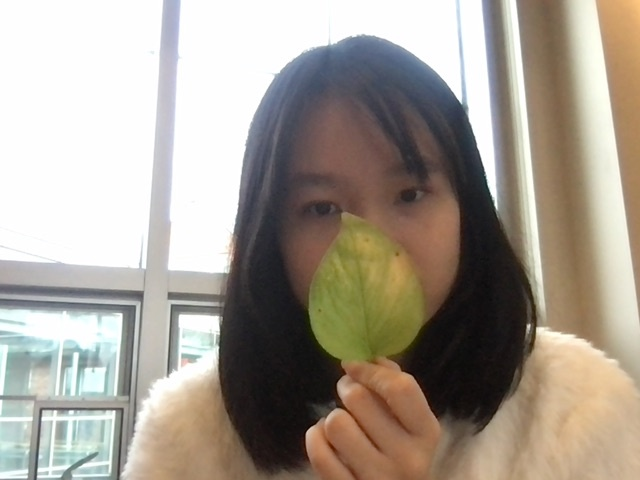

In [46]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

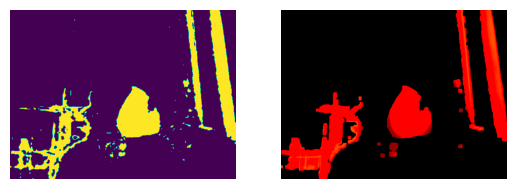

In [47]:
segment('/content/photo.jpg')